In [20]:
import pandas as pd 
import numpy as np
from scipy.signal import correlate, correlation_lags
import scipy.cluster.hierarchy as hcluster
from datetime import datetime
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
import requests
from pprint import pprint
import copy
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import statsmodels.api as sm
from scipy import stats
from datetime import datetime, timedelta
import itertools
import matplotlib.dates as mdates
import plotly.graph_objects as go 
fmt = mdates.DateFormatter('%d-%b\n%Y') 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%d-%b\n%Y')  
import matplotlib.pyplot as plt
import warnings
from get_data import *
#from translate import Translator
warnings.filterwarnings("ignore")

In [2]:
%%time
data_types = ['cases', 'hosp', 'test']
georegion = ['GE']

df = get_combined_data( data_types, georegion,vaccine = True, smooth = True)
df = df.iloc[:-3]
# remove the last 3 days to avoid delay in data
df

CPU times: user 1.18 s, sys: 576 ms, total: 1.76 s
Wall time: 3min 45s


,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE,test_GE,diff_test_GE,diff_2_test_GE,vac_all
datum,,,,,,,,,,
2020-03-01,1.428571,0.142857,0.142857,0.428571,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000
2020-03-02,1.714286,0.285714,0.142857,0.428571,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-03,1.714286,0.000000,-0.285714,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-04,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-05,1.857143,0.142857,0.142857,0.857143,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-01-12,2503.428571,-20.285714,-17.285714,18.000000,-1.000000,0.857143,7067.142857,-44.142857,-122.714286,164.942857
2022-01-13,2501.571429,-1.857143,18.428571,16.714286,-1.285714,-0.285714,7072.000000,4.857143,49.000000,165.700000
2022-01-14,2470.428571,-31.142857,-29.285714,14.571429,-2.142857,-0.857143,6906.000000,-166.000000,-170.857143,166.440000


In [9]:
def lgbm_model(params=None, **kwargs):
    '''
    Return an LGBM model
    :param kwargs:
    :return: LGBMRegressor model
    '''
    if params is None:
        params = {
            'n_jobs': 8,
            'max_depth': 4,
            'max_bin': 63,
            'num_leaves': 255,
#             'min_data_in_leaf': 1,
            'subsample': 0.9,
            'n_estimators': 200,
            'tree_learner': 'feature', 
            'learning_rate': 0.1,
            'colsample_bytree': 0.9,
            'boosting_type': 'gbdt'
        }


    model = lgb.LGBMRegressor(objective='regression', **params)

    return model 


In [9]:
def rolling_predictions_one(target_name,T,  data, ini_date = '2020-03-01',split = 0.75, maxlag=14):


    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )

    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()



    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)


    # targets 
    targets = {}
    
    horizon_forecast = T
            
    targets[T] = target.shift(-(T - 1))[:-(T - 1)]
    
    print('size of df_lag', len(df_lag))
    print('size of targets', len(targets[T]))

    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)

    idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
    
    idx = idx.to_timestamp()

    # predictions 
    tgt = targets[T][:len(X_train)]

    
    model50 = lgbm_model()
   
    model50.fit(X_train, tgt)
    
    glm_poisson  = sm.GLM(tgt, X_train, family=sm.families.Poisson())
    glm_res = glm_poisson.fit()
   
    pred50 = model50.predict(df_lag.iloc[:len(targets[T])])
    predglm = glm_res.predict(df_lag.iloc[:len(targets[T])])
    
    # transformando preds em um array
    train_size = len(X_train)
    point = targets[T].index[train_size]

    #pred_window = preds5.shape[1]
    #llist = range(len(targets[1].index) - (preds5.shape[1]))
    
    
    #print(llist)

    y50 = np.array(pred50)
    
    yglm = np.array(predglm)

    x= pd.period_range(start=df_lag.index[T], end=df_lag.index[-1], freq='D').to_timestamp()
    
    x = np.array(x)
    
    target = targets[T]
    
    train_size = len(X_train)
    
    dif = len(x) - len(y50)
        
    if dif <0:
        y50 = y50[:len(y50) + dif]
        
    df = pd.DataFrame()
    df['target'] = target[1:]
    df['date'] = x
    df['glm'] = yglm[1:]
    df['median'] = y50
    #df['upper'] = y95
    df['train_size'] = [train_size]*len(df)
    
    return df

In [10]:
target_name = 'hosp_GE'

#df_t = df.loc['2020-07-01':]
T = 14

df_preds = rolling_predictions_one(target_name,T,  df, ini_date = '2020-03-01',split = 0.75, maxlag=14)

df_preds

NameError: name 'df' is not defined

In [ ]:
fig, ax = plt.subplots(dpi = 150)

ax.plot(df_preds.target, label = 'Data', color = 'black')

ax.axvline(df_preds.index[df_preds.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')

ax.plot(df_preds['median'], label = 'Median', ls = '--')

ax.plot(df_preds.glm, label = 'Poisson', ls = '--')

ax.xaxis.set_major_formatter(fmt)

ax.grid()

ax.legend()

plt.show()


Usando o modelo LGBM como correção:

In [ ]:
len(df)

In [ ]:
np.arange(90, len(df)-14, 14)

In [ ]:
np.concatenate(([1,2], [3,4]))

In [53]:
def rolling_predictions(target_name,T,  data, ini_date = '2020-03-01',split = 0.75, maxlag=14):


    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )

    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()

    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)


    # targets 
    targets = {}
    
    horizon_forecast = T
            
    targets[T] = target.shift(-(T - 1))[:-(T - 1)]
    
    print('size of df_lag', len(df_lag))
    print('size of targets', len(targets[T]))
    
    preds_end = np.array([])
    
    y = np.array([])
    
    for i in np.arange(90,  510, 14):
    
        X_train = df_lag.iloc[:i]
        
        y_train = targets[T][:len(X_train)]
        
        X_test = df_lag.iloc[i:i+14]
        
        y_test = targets[T][i:i+14]
          
        knn  = MLPRegressor(random_state=1, max_iter=500, activation = 'relu', shuffle = False).fit(X_train, y_train) #, family=sm.families.Poisso
    
    #glm_poisson  = sm.GLM(tgt, X_train, family=sm.families.Poisson())
    #glm_res = glm_poisson.fit()
   
        pred50 = knn.predict(X_test)
    
        #print(len(pred50))
        
        #print(len(y_test))

        preds_end = np.concatenate( (preds_end, pred50) )
        
        y = np.concatenate( (y, y_test.values ))
        
    X_gml = df_lag.iloc[90:510]
    X_gml['preds_poisson'] = preds_end
    
    model  = lgbm_model()#(y, X_gml,family=sm.families.Poisson())
    
    model.fit(X_gml, y)
    
    
    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)

    idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
    
    idx = idx.to_timestamp()

    # predictions 
    tgt = targets[T][:len(X_train)]
    
    knn  = MLPRegressor(random_state=1, max_iter=500, activation = 'relu', shuffle = False).fit(X_train, tgt)


    y_poisson = knn.predict(df_lag.iloc[:len(targets[T])])
    
    X_glm_at = df_lag.iloc[:len(targets[T])]

    X_glm_at['preds_poisson'] = y_poisson
    
    pred_lgbm = model.predict(X_glm_at)
    
    # transformando preds em um array
    train_size = len(X_train)
    point = targets[T].index[train_size]

    #pred_window = preds5.shape[1]
    #llist = range(len(targets[1].index) - (preds5.shape[1]))
    
    
    #print(llist)

    y50 = np.array(y_poisson)
    
    pred_lgbm = np.array(pred_lgbm)

    x= pd.period_range(start=df_lag.index[T], end=df_lag.index[-1], freq='D').to_timestamp()
    
    x = np.array(x)
    
    target = targets[T]
    
    train_size = len(X_train)
    
    dif = len(x) - len(y50)
        
    if dif <0:
        y50 = y50[:len(y50) + dif]
        
    df = pd.DataFrame()
    df['target'] = target[1:]
    df['date'] = x
    df['lgbm'] = pred_lgbm[1:]
    df['median'] = y50
    #df['upper'] = y95
    df['train_size'] = [train_size]*len(df)
    
    return preds_end, y, df
    

In [54]:
np.arange(90, 510, 14)

array([ 90, 104, 118, 132, 146, 160, 174, 188, 202, 216, 230, 244, 258,
       272, 286, 300, 314, 328, 342, 356, 370, 384, 398, 412, 426, 440,
       454, 468, 482, 496])

In [55]:
len(df.iloc[90:636+14])

560

In [56]:
%%time
preds, y, df_poisson = rolling_predictions('hosp_GE',14,  df, ini_date = '2020-03-01',split = 0.75, maxlag=14)

size of df_lag 673
size of targets 660
CPU times: user 57.8 s, sys: 9.47 s, total: 1min 7s
Wall time: 8.84 s


In [57]:
y.shape

(420,)

In [58]:
preds.shape

(420,)

In [59]:
df_poisson

,target,date,lgbm,median,train_size
datum,,,,,
2020-03-16,16.428571,2020-03-29,5.303421,9.820119,504
2020-03-17,16.857143,2020-03-30,5.098372,9.806389,504
2020-03-18,16.571429,2020-03-31,9.160908,13.340255,504
2020-03-19,16.142857,2020-04-01,9.684296,17.503255,504
2020-03-20,16.142857,2020-04-02,8.865239,18.864499,504
...,...,...,...,...,...
2021-12-30,18.000000,2022-01-12,10.186557,3.646875,504
2021-12-31,16.714286,2022-01-13,10.494641,2.169881,504
2022-01-01,14.571429,2022-01-14,10.530176,15.205852,504


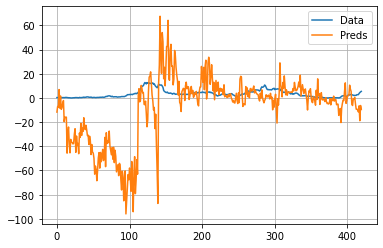

In [60]:
fig ,ax = plt.subplots()

ax.plot( y, label = 'Data')

ax.plot(preds, label = 'Preds')

ax.legend()

ax.grid()

In [61]:
df.index[650]

Timestamp('2021-12-11 00:00:00', freq='D')

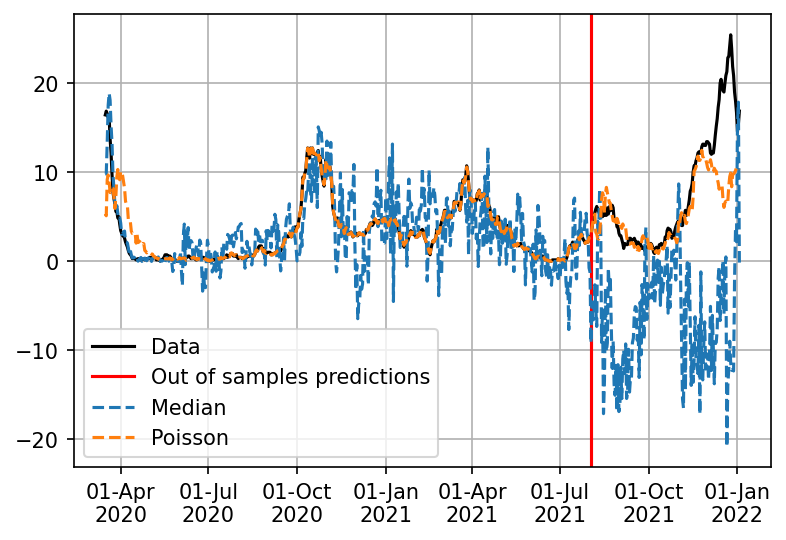

In [62]:
fig, ax = plt.subplots(dpi = 150)

ax.plot(df_poisson.target, label = 'Data', color = 'black')

ax.axvline(df_poisson.index[df_poisson.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')

ax.plot(df_poisson['median'], label = 'Median', ls = '--')

ax.plot(df_poisson.lgbm, label = 'Poisson', ls = '--')

ax.xaxis.set_major_formatter(fmt)

ax.grid()

ax.legend()

plt.show()

In [32]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
df_m = pd.DataFrame()

df_m['LightGBM'] = [mse(df_poisson.target.iloc[df_poisson.train_size[0]:].values, df_poisson['median'][df_poisson.train_size[0]:]), mae(df_poisson.target.iloc[df_poisson.train_size[0]:].values, df_poisson['median'][df_poisson.train_size[0]:])]

df_m['Poisson'] = [mse(df_poisson.target.iloc[df_poisson.train_size[0]:].values, df_poisson.glm[df_poisson.train_size[0]:]), mae(df_poisson.target.iloc[df_poisson.train_size[0]:].values, df_poisson.glm[df_poisson.train_size[0]:])]

df_m.index = ['MSE', 'MAE']

df_m